# Implementation of Vanilla GANs model with Gaussian dataset
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

import numpy as np
import datetime
import os, sys
import random

random.seed(42)
np.random.seed(42)

from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")
DATASET = '25gaussians'
NO_OF_BATCHES = 100
BATCH_SIZE = 64
max_epoch = 100 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 2

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [6]:
def generate_image(dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    for idx in range(NO_OF_BATCHES):
        plt.scatter(dist[idx][:,0], dist[idx][:,1], c='blue', marker='+')

    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    z_outputs = G(z)
    
    z_outputs = z_outputs.cpu().detach().numpy()
    
    plt.scatter(z_outputs[:,0], z_outputs[:,1], c='red', marker='+')
    plt.show()

In [7]:
def inf_train_gen():
    if DATASET == '25gaussians':

        dataset = []
        for i in range(int(100000 / 25)):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        np.random.shuffle(dataset)
        dataset /= 2.828  # stdev
        while True:
            for i in range(int(len(dataset) / BATCH_SIZE)):
                yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE,
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data

    elif DATASET == '8gaussians':

        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2) * .02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype='float32')
            dataset /= 1.414  # stdev
            yield dataset


In [8]:


D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

data = inf_train_gen()

train = []

for _ in range(NO_OF_BATCHES):
    data_ = next(data)
    train.append(data_)

train = np.array(train)

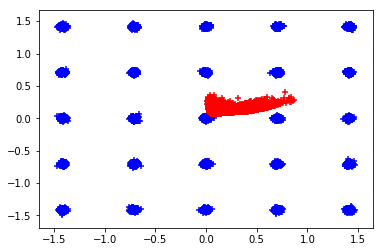

In [10]:
generate_image(train)

Epoch: 0/100, Step: 0, D Loss: 1.406477928161621, G Loss: 0.6916172504425049


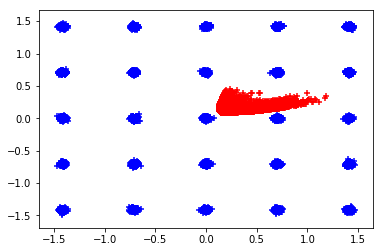

Epoch: 5/100, Step: 500, D Loss: 1.3847012519836426, G Loss: 0.7232331037521362


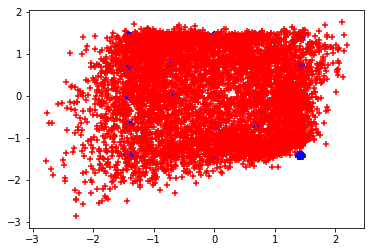

Epoch: 10/100, Step: 1000, D Loss: 1.3608460426330566, G Loss: 0.7345947027206421


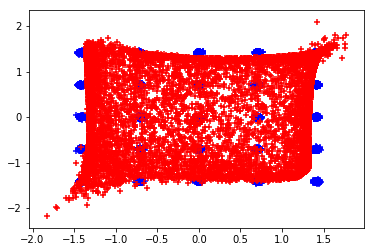

Epoch: 15/100, Step: 1500, D Loss: 1.394989013671875, G Loss: 0.7024509310722351


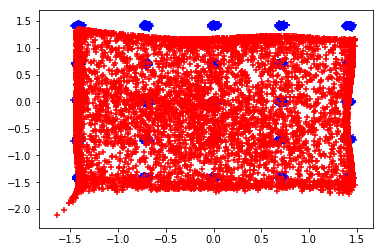

Epoch: 20/100, Step: 2000, D Loss: 1.3826253414154053, G Loss: 0.6914738416671753


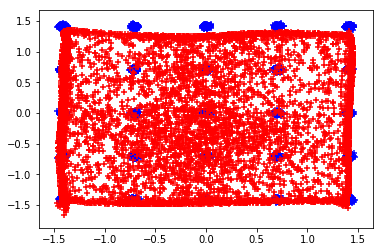

Epoch: 25/100, Step: 2500, D Loss: 1.2948315143585205, G Loss: 0.7339064478874207


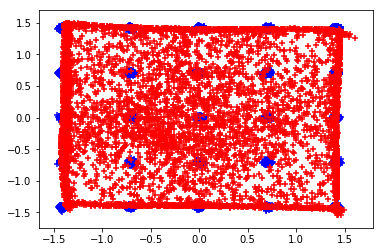

Epoch: 30/100, Step: 3000, D Loss: 1.2589716911315918, G Loss: 0.7768226861953735


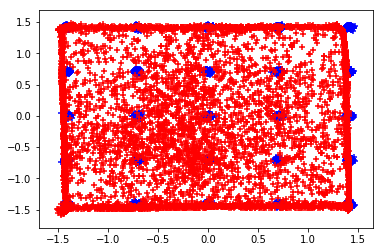

Epoch: 35/100, Step: 3500, D Loss: 1.1539918184280396, G Loss: 0.8313050270080566


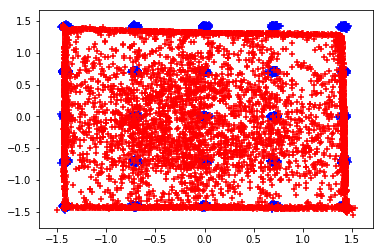

Epoch: 40/100, Step: 4000, D Loss: 1.0660638809204102, G Loss: 0.7645267844200134


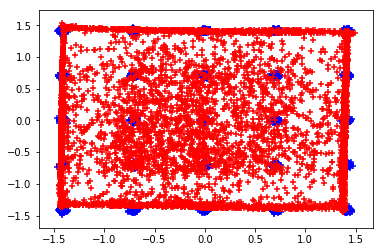

Epoch: 45/100, Step: 4500, D Loss: 1.0369012355804443, G Loss: 1.0260558128356934


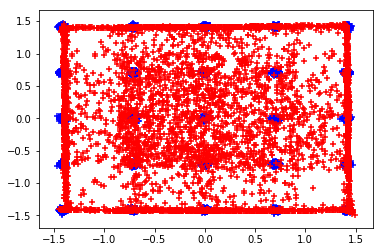

Epoch: 50/100, Step: 5000, D Loss: 1.046750545501709, G Loss: 1.098665714263916


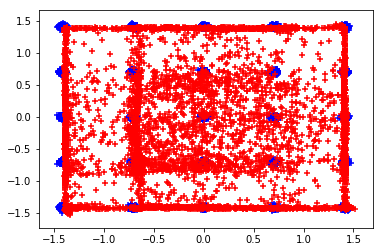

Epoch: 55/100, Step: 5500, D Loss: 0.9063405394554138, G Loss: 0.9883305430412292


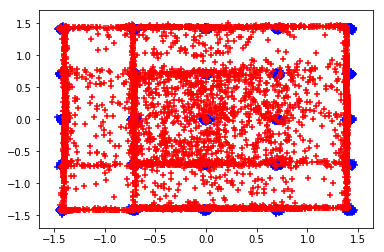

Epoch: 60/100, Step: 6000, D Loss: 1.0414705276489258, G Loss: 1.139406681060791


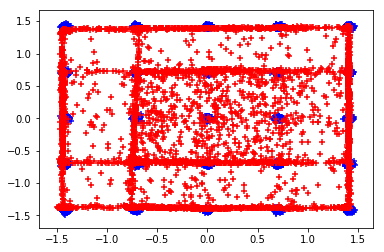

Epoch: 65/100, Step: 6500, D Loss: 1.1245787143707275, G Loss: 1.0763046741485596


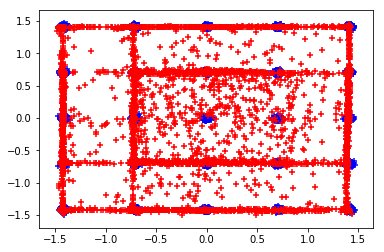

Epoch: 70/100, Step: 7000, D Loss: 1.040956974029541, G Loss: 0.8007945418357849


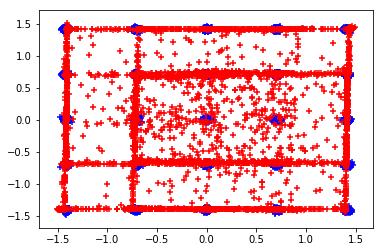

Epoch: 75/100, Step: 7500, D Loss: 1.1024577617645264, G Loss: 0.9734538793563843


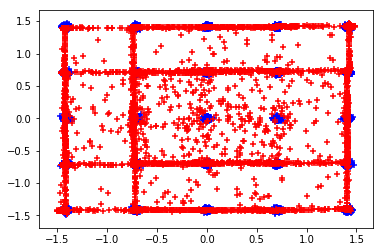

Epoch: 80/100, Step: 8000, D Loss: 1.0273383855819702, G Loss: 1.0964598655700684


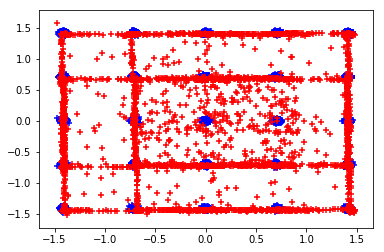

Epoch: 85/100, Step: 8500, D Loss: 1.1468310356140137, G Loss: 1.2588648796081543


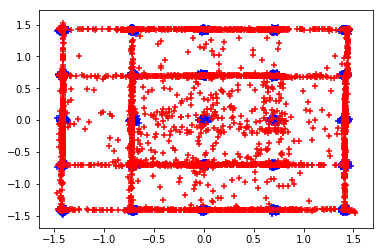

Epoch: 90/100, Step: 9000, D Loss: 1.1494882106781006, G Loss: 0.9781256318092346


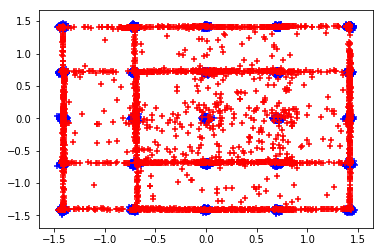

Epoch: 95/100, Step: 9500, D Loss: 1.1588833332061768, G Loss: 0.9419485926628113


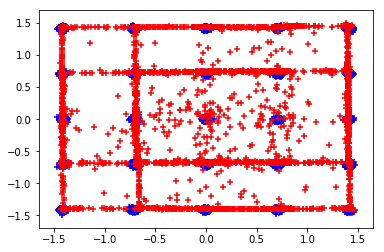

In [11]:
for epoch in range(max_epoch):
    for idx, x in enumerate(train):
        # Training Discriminator
        
        x = torch.Tensor(x)

        if DEVICE == torch.device("cuda"):
            x = x.cuda()
        
        x = torch.autograd.Variable(x)  
        x_outputs = D(x)      

        D_x_loss = criterion(x_outputs, D_labels)


        z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            generate_image(train)
        step += 1